In [9]:
%load_ext autoreload
%autoreload 2

from matplotlib import dates
from pandas import DataFrame
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import quantstats as qs
import talib.abstract as ta
import os
import time
import inspect
import stackprinter

stackprinter.set_excepthook(style='darkbg2')  # for jupyter notebooks try style='lightbg'

if "freqtrade" not in os.listdir():
        os.chdir("..")
        import nest_asyncio
        nest_asyncio.apply()

from freqtrade.nbtools.preset import Preset

qs.extend_pandas()
plt.style.use("seaborn")

path_mount = Path.cwd().parent / "mount"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jliberooo (use `wandb login --relogin` to force relogin)


In [29]:
# Test Load Local Backtester
local_preset_path = path_mount / "presets_downloaded" / "15m-next30m-combine"
local_datadir = path_mount / "data" / "binance"

preset_local, strategy_code = Preset.from_local(local_preset_path)
preset_local.datadir = local_datadir
preset_local.timerange = "20210501-20210505"
stats, summary = preset_local.backtest_by_default_strategy_code()
print(summary)

wandb: Downloading large artifact 15m-next30m-spot-v2_new.pkl:latest, 60.08MB. 1 files... Done. 0:0:0


wandb: Adding directory to artifact (.\.temp\15m-next30m-combine__backtest-2021-07-10_23-12-56)... Done. 0.0s


'Result for strategy NotebookStrategy\n=========================================================== BACKTESTING REPORT ==========================================================\n|       Pair |   Buys |   Avg Profit % |   Cum Profit % |   Tot Profit USDT |   Tot Profit % |   Avg Duration |   Win  Draw  Loss  Win% |\n|------------+--------+----------------+----------------+-------------------+----------------+----------------+-------------------------|\n|   VET/USDT |      2 |           2.77 |           5.54 |             0.832 |           0.08 |        0:30:00 |     2     0     0   100 |\n|   ENJ/USDT |      1 |           2.63 |           2.63 |             0.396 |           0.04 |        0:30:00 |     1     0     0   100 |\n|  COMP/USDT |      1 |           2.48 |           2.48 |             0.372 |           0.04 |        0:30:00 |     1     0     0   100 |\n|   FTM/USDT |      1 |           1.95 |           1.95 |             0.293 |           0.03 |        0:30:00 |     1     0    

In [35]:
print(strategy_code)

""" Sample Strategy with Load Asset"""
# For the pkl file, it is at: https://drive.google.com/file/d/1-L3ZQAOsBIpYa5ibStH84Edle8XOCGn_/view?usp=sharing
from numpy.lib.npyio import save, savez_compressed
from numpy.lib.utils import info
from pandas import DataFrame
import numpy as np  # noqa
import pandas as pd  # noqa
from freqtrade.strategy import IStrategy, merge_informative_pair
from freqtrade.nbtools.remote_utils import load_pickle_asset
# --------------------------------
# Add your lib to import here
import talib.abstract as ta
import freqtrade.vendor.qtpylib.indicators as qtpylib
import dill
import sklearn
import marshal
import types
import os
import logging
import inspect

logger = logging.getLogger(__name__)

MODELS = {
    "15m-next30m-spot-v2_new.pkl": None,
    "15m-next30m-10_06_new.pkl": None,
}


def use_ml_model(dataframe):
    predictions = pd.DataFrame()
    
    for modelname in MODELS.keys():
        
        if MODELS[modelname] is None:
            load_saved_model(modelname)
            
        # Load saved model and it's feature function.
        saved_model_dict = MODELS[modelname]
        saved_model_dict["add_features_function"](dataframe, saved_model_dict["config"]["num_next_candle"])

        # Model predictions
        model = saved_model_dict["model"]
        col_use = saved_model_dict["config"]["col_use"]
        preds = pd.DataFrame(model.predict_proba(dataframe[col_use]))
        preds.columns = [f"pred{i}" for i in range(5)]
        predictions[modelname] = preds["pred4"]
        
    return predictions


def load_saved_model(modelname: str):
    """NOTE: This is where we use cloud to load "big" assets"""
    saved_model = load_pickle_asset("legacy-models", modelname)
    MODELS[modelname] = saved_model
    logger.info(f"\n[=== LOADED SAVED MODEL: {modelname} ====]")
    logger.info("[=== SAVED MODEL: CONFIG ====]")
    logger.info(saved_model["config"])
    logger.info("[=== SAVED MODEL: ADD FEATURES FUNCTION ===]")
    logger.info(saved_model["add_features_function_str"])
    logger.info("[============================]\n")


trendline_period = { 
    "1m": 8000, "5m": 1600, "15m": 800, "30m": 400,
    "1h": 200, "2h": 100, "4h": 50, "6h": 25, "12h": 13, "1d": 7
}
use_trendline = False
use_btc_trendline = False
trendline_mult = 1.2 # Step 0.05
trendline_method = ["MA", "EMA", "DEMA", "TEMA", "HULLMA"]
threshold_bull = 0.68 # Step 0.025. Current optimum 0.68 with NO TRENDLINE


class NotebookStrategy(IStrategy):
    INTERFACE_VERSION = 2
    timeframe = '15m'
    minimal_roi = {"30": -1000}
    stoploss = -0.99
    trailing_stop = False
    process_only_new_candles = False
    use_sell_signal = True
    sell_profit_only = False
    ignore_roi_if_buy_signal = True
    startup_candle_count: int = 800
    order_types = {
        'buy': 'limit',
        'sell': 'limit',
        'stoploss': 'market',
        'stoploss_on_exchange': False
    }
    order_time_in_force = {
        'buy': 'gtc',
        'sell': 'gtc'
    }

    def informative_pairs(self):
        pairs = self.dp.current_whitelist()
        informative_pairs = [(pair, self.timeframe) for pair in pairs]
        informative_pairs += [("BTC/USDT", self.timeframe)]
        return informative_pairs

    def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
        # Define your "filter" indicators here!
        self.df_close = "close"
        self.df_trendline = "trendline"
        dataframe["date"] = pd.to_datetime(dataframe["date"], unit='ms')
        dataframe["trendline"] = ta.EMA(dataframe, timeperiod=int(trendline_period[self.timeframe] * trendline_mult))
        
        predictions = use_ml_model(dataframe)
        dataframe = dataframe.reset_index(drop=True)
        dataframe = pd.concat([dataframe, predictions], axis=1)
        
        if self.dp and use_btc_trendline:
            # Add BTC/USDT to our data
            informative = self.dp.get_pair_dataframe(pair="BTC/USDT", timeframe=self.timeframe)
            informative['btctrend'] = ta.EMA(informative, timeperiod=int(trendline_period[self.timeframe] * trendline_mult))
            dataframe = merge_informative_pair(dataframe, informative, self.timeframe, self.timeframe, ffill=True)
            self.df_close = f"close_{self.timeframe}"
            self.df_trendline = f"btctrend_{self.timeframe}"
        
        # print(list(dataframe.columns))
        return dataframe

    def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
        if use_trendline:
            dataframe.loc[
                (
                    (
                        (dataframe['15m-next30m-spot-v2_new.pkl'] > threshold_bull) &  # Default: 0.45
                        (dataframe[self.df_close] > dataframe[self.df_trendline])
                    ) &
                    (dataframe['volume'] > 0)  # Make sure Volume is not 0
                ),
                'buy'] = 1
        else:
            dataframe.loc[
                (
                    (dataframe['15m-next30m-spot-v2_new.pkl'] > threshold_bull) &
                    (dataframe['volume'] > 0)  # Make sure Volume is not 0
                ),
                'buy'] = 1
        return dataframe

    def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
        if use_trendline:
            dataframe.loc[
                (
                    (
                        # (dataframe['15m-next30m-spot-v2_new.pkl'] < 0.45) |  # Default: 0.28
                        (dataframe[self.df_close] < dataframe[self.df_trendline])
                    ) &
                    (dataframe['volume'] > 0)  # Make sure Volume is not 0
                ),
                'sell'] = 0
        else:
            dataframe['sell'] = 0
        return dataframe

# For the pkl file, it is at: https://drive.google.com/file/d/1-L3ZQAOsBIpYa5ibStH84Edle8XOCGn_/view?usp=sharing
from numpy.lib.npyio import save, savez_compressed
from numpy.lib.utils import info
from pandas import DataFrame
import numpy as np  # noqa
import pandas as pd  # noqa
from freqtrade.strategy import IStrategy, merge_informative_pair
from freqtrade.nbtools.remote_utils import load_pickle_asset
# --------------------------------
# Add your lib to import here
import talib.abstract as ta
import freqtrade.vendor.qtpylib.indicators as qtpylib
import dill
import sklearn
import marshal
import types
import os
import logging
import inspect

logger = logging.getLogger(__name__)

MODELS = {
    "15m-next30m-spot-v2_new.pkl": None,
    "15m-next30m-10_06_new.pkl": None,
}


def use_ml_model(dataframe):
    predictions = pd.DataFrame()
    
    for modelname in MODELS.keys():
        
        if MODELS[modelname] is None:
            load_saved_model(modelname)
            
        # Load

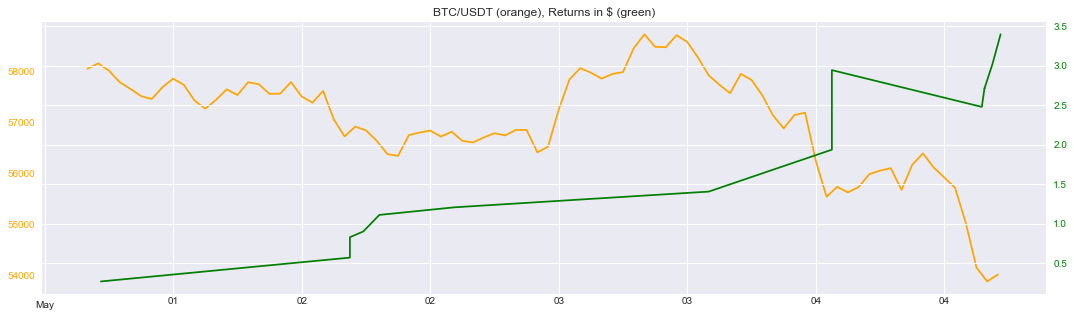

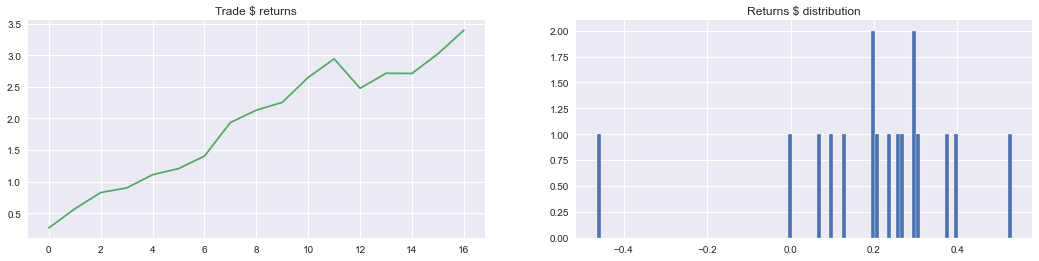

Portfolio Summary
------------------------------
Min Balance          : 0.27
Max Balance          : 3.40
End Balance          : 3.40
------------------------------
Trades               : 17
Avg. Profit $        : 0.20
Biggest Profit $     : 0.53
Biggest Loss $       : -0.47
------------------------------
Sharpe               : 10.55


In [33]:
def plot_profits(trades_data, start, end):
    trades = trades_data.copy()
    start = pd.Timestamp(start, tz="UTC")
    if start < trades["open_date"].min():
        start = trades["open_date"].min()
    end = pd.Timestamp(end, tz="UTC")
    if end > trades["close_date"].max():
        end = trades["close_date"].max()
    
    # Section 1.1: BTC/USDT price over time
    btc_usdt_df = pd.read_json(path_mount / "data" / "binance" / "BTC_USDT-15m.json")
    btc_usdt_df.columns = ["date", "open", "high", "low", "close", "volume"]
    btc_usdt_df["date"] = pd.to_datetime(btc_usdt_df["date"], unit="ms", utc=True)
    btc_usdt = btc_usdt_df.loc[(btc_usdt_df["date"] >= start) & (btc_usdt_df["date"] <= end)]
    btc_usdt = btc_usdt.set_index("date").resample("1h").mean()
    fig, ax1 = plt.subplots(figsize=(18, 5))
    ax1.plot(btc_usdt["close"], color='orange', label="BTC/USDT")
    ax1.tick_params(axis='y', labelcolor='orange')

    # Section 1.2: Cumulative profit $ over time
    targetted_time_trades = trades.loc[(trades.open_date >= start) & (trades.close_date <= end)]
    targetted_time_trades = targetted_time_trades.set_index("close_date")
    profits_usd = targetted_time_trades.profit_abs.cumsum()
    ax2 = ax1.twinx()
    ax2.plot(profits_usd, color='green', label="Returns")
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.xaxis.set_major_formatter(dates.DateFormatter('%b'))
    ax2.xaxis.set_major_locator(dates.MonthLocator(interval=1))
    ax2.xaxis.set_minor_formatter(dates.DateFormatter('%d'))
    ax2.xaxis.set_minor_locator(dates.AutoDateLocator())
    
    # Styloze and plot our section 1
    plt.title("BTC/USDT (orange), Returns in $ (green)")
    color = "white"
    ax1.grid(b=True, which='major', color=color, linestyle='-', axis="x", alpha=1)
    ax1.grid(b=True, which='minor', color=color, linestyle='-', axis="x", alpha=1)
    ax1.grid(b=True, which='major', color=color, linestyle='-', axis="y", alpha=1)
    ax2.grid(b=True, which='major', color=color, linestyle='-', axis="x", alpha=1)
    ax2.grid(b=True, which='minor', color=color, linestyle='-', axis="x", alpha=1)
    ax2.grid(b=True, which='both', color=color, linestyle='-', axis="y", alpha=1)
    ax1.grid(b=False, which='both', axis="y")
    plt.show()
        
    # Section 2: Create [left and right] plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 4))
    
    # Section 2.1 Left: Profit $ with trades cumulative
    ax1.plot(list(trades.profit_abs.cumsum()), color="g")
    ax1.set_title("Trade $ returns")
    
    # Section 2.2 Right: Profit $ distribution histogram
    mean_profits = trades.profit_abs.mean()
    std_profits = trades.profit_abs.std()
    ax2.hist(trades.profit_abs.clip(mean_profits - 4*std_profits, mean_profits + 4*std_profits), bins=100)
    ax2.set_title("Returns $ distribution")
    plt.show()
    
    # Print Portfolio Summary
    print("Portfolio Summary")
    print("------------------------------")
    print("Min Balance          : %.2f" % min(profits_usd))
    print("Max Balance          : %.2f" % max(profits_usd))
    print("End Balance          : %.2f" % profits_usd[-1])
    print("------------------------------")
    print("Trades               : %i" % len(profits_usd))
    print("Avg. Profit $        : %.2f" % (profits_usd[-1] / len(profits_usd)))
    print("Biggest Profit $     : %.2f" % trades.profit_abs.max())
    print("Biggest Loss $       : %.2f" % trades.profit_abs.min())
    print("------------------------------")
    print("Sharpe               : %.2f" % trades.profit_abs.cumsum().pct_change().sharpe())
    # TODO: Max Drawdown, Return / Drawdown

trades = pd.DataFrame(stats["strategy"]["NotebookStrategy"]["trades"])
plot_profits(trades, "2021-01-01", "2021-12-31")

In [7]:
trades_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   open_date     700 non-null    datetime64[ns, UTC]
 1   open_rate     700 non-null    float64            
 2   close_date    700 non-null    datetime64[ns, UTC]
 3   close_rate    700 non-null    float64            
 4   sell_reason   700 non-null    object             
 5   profit_ratio  700 non-null    float64            
 6   profit_abs    700 non-null    float64            
dtypes: datetime64[ns, UTC](2), float64(4), object(1)
memory usage: 38.4+ KB


In [12]:
# Upload "big_files"
from freqtrade.nbtools import remote_utils
from pathlib import Path

project = "legacy-models"
for path in (path_mount / "big_files").glob("*.pkl"):
    remote_utils.add_single_asset(str(path), project, path.name.lower().replace(" ", ""))